In [5]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2022-11-24 18:18:37.869604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
#Declaring some required variables
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE*4
os.listdir('/kaggle/input/')

['hindi-english-truncated-corpus']

In [7]:
#DataSet is taken from Kaggle

train_df=pd.read_csv("/kaggle/input/hindi-english-truncated-corpus/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')
train_df.drop(['source'],axis=1,inplace=True)
mask = (train_df['english_sentence'].str.len()>20) & (train_df['english_sentence'].str.len()<200)
train_df = train_df.loc[mask]
train_df = train_df.sample(64000, random_state=1)
train_df.head()

,english_sentence,hindi_sentence
63241,Indian News Service - National News Agency,इण्डियन न्यूज सर्विस - राष्ट्रीय समाचार एजेंसी
81404,"In West Bengal , it seems set to eat humble pi...",पश्चिम बंगाल में तो वह अपमान का घूंट पीने को भ...
8803,One american dollar is equal to 60 pakistani r...,एक अमरीकी डालर की कीमत लगभग ६० पाकिस्तानी रुपय...
73434,"but between those high highs,",लेकिन इन बेहतरीन लम्हों के बीच
65711,Every other politician went along because when...,और वजह यह थी कि आर्थिक मामलं पर हमेशा विफल विच...


In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
#Adding <SOS> and <END> tokens 

eng = train_df['english_sentence']
hind = train_df['hindi_sentence']
eng = eng.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
hind = hind.apply(lambda x: "<SOS> "+ x + " <EOS>")

In [10]:
#Text Preprocessing for Model

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs = eng_tokenizer.texts_to_sequences(eng)
targets = hind_tokenizer.texts_to_sequences(hind)

In [11]:
#Vocabulary size

ENCODER_VOCAB = len(eng_tokenizer.word_index) + 1
DECODER_VOCAB = len(hind_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

44305 51960


In [12]:
#Padding the inputs

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

2022-11-24 18:18:50.189513: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-24 18:18:50.193287: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-24 18:18:50.257871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 18:18:50.258581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-11-24 18:18:50.258665: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-24 18:18:50.290137: I tensorflow/stream_executor/platform/def

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
#Code for Implementing Transformer Model


def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [19]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [20]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 50

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [22]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

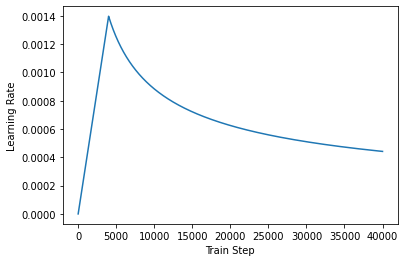

In [23]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [25]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [26]:
#Defining the Transformer based model

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [27]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [28]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [29]:
#training the model

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

2022-11-24 18:19:00.578922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-24 18:19:00.625342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz
2022-11-24 18:19:01.856678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-24 18:19:02.760079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


Epoch 1 Batch 0 Loss 10.8624 Accuracy 0.0000
Epoch 1 Batch 200 Loss 10.5045 Accuracy 0.0461
Epoch 1 Batch 400 Loss 9.6674 Accuracy 0.0534
Epoch 1 Loss 9.2536 Accuracy 0.0548
Time taken for 1 epoch: 213.77793836593628 secs

Epoch 2 Batch 0 Loss 7.3922 Accuracy 0.0548
Epoch 2 Batch 200 Loss 7.2223 Accuracy 0.0609
Epoch 2 Batch 400 Loss 6.9997 Accuracy 0.0729
Epoch 2 Loss 6.9069 Accuracy 0.0785
Time taken for 1 epoch: 203.1153702735901 secs

Epoch 3 Batch 0 Loss 6.4680 Accuracy 0.0786
Epoch 3 Batch 200 Loss 6.3398 Accuracy 0.0895
Epoch 3 Batch 400 Loss 6.2269 Accuracy 0.0993
Epoch 3 Loss 6.1762 Accuracy 0.1037
Time taken for 1 epoch: 203.43533205986023 secs

Epoch 4 Batch 0 Loss 6.0061 Accuracy 0.1037
Epoch 4 Batch 200 Loss 5.8345 Accuracy 0.1120
Epoch 4 Batch 400 Loss 5.7439 Accuracy 0.1200
Epoch 4 Loss 5.7014 Accuracy 0.1238
Time taken for 1 epoch: 203.5463559627533 secs

Epoch 5 Batch 0 Loss 5.4949 Accuracy 0.1238
Epoch 5 Batch 200 Loss 5.3987 Accuracy 0.1311
Epoch 5 Batch 400 Loss 5.3

In [30]:
#Lets make predictions

def evaluate(text):
    text = eng_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [hind_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [31]:
def translate(eng_text):
    hind_text = evaluate(text=eng_text)[0].numpy()
    hind_text = np.expand_dims(hind_text[1:], 0)  
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

# Predictions

Below are 2 translation predictions, the first one is on a sentence that was in the dataset and the other one that I wrote 
by myself.

In [32]:
translate("I am a student and I like to study very much.")

'मैं एक छात्र हूं और मैं बहुत ही पढ़ने करना चाहता हूं'

In [33]:
translate("I am very happy about my family")

'मैं अपने परिवार के बारे मेरे परिवार के बारे में बहुत बहुत खुश हूँ'

In [34]:
translate("I want to play cricket")

'मैं क्रिकेट खेल खेल खेल रहा हूँ और मैं क्रिकेट खेल रहा हूँ'

In [35]:
transformer.save_weights('model.h5')